# Chapter 15: Processing Sequences using RNNs and CNNs

In [1]:
# Libraries
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Seeds
np.random.seed(42)
tf.random.set_seed(42)

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 1. Basic RNNs

### 1.1 Example: time series imputation

#### 1.1.1 Preliminaries

First, generate the example dataset

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    # wave 1
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
    # + wave 2
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
    # + noise
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) 
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)

In [9]:
# Train, test split
x_train, y_train = series[:7000, :n_steps], series[:7000, -1]
x_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
x_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [10]:
x_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Dealing with 7000 different time series examples, each over 50 time steps

In [11]:
# Plotting function
def plot_series(series, y = None, y_pred = None, x_label = "$t$", y_label = "$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize = 10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize = 16)
    if y_label:
        plt.ylabel(y_label, fontsize = 16, rotation = 0)
    plt.hlines(0, 0, 100, linewidth = 1)
    plt.axis([0, n_steps + 1, -1, 1])

Plot the example time series; goal forecast point shown as blue $x$

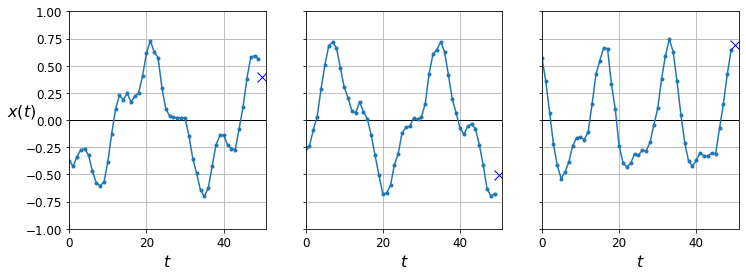

In [12]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, sharey = True, figsize = (12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(x_valid[col, :, 0], y_valid[col, 0],
               y_label = ("$x(t)$" if col == 0 else None))
plt.show()

#### 1.2 Baseline metrics

__Naive forecasting__ : predict last value in each series

In [13]:
y_pred = x_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred)) # mse

0.020211367

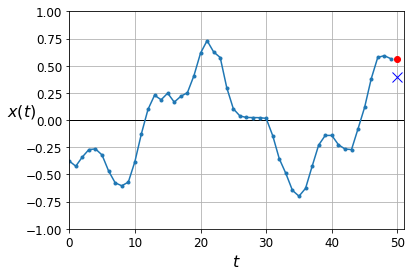

In [14]:
# How does naive forecast compare visually?
plot_series(x_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Another simple model: _linear regression_

Here, using `keras` implementation - training via Adam optimization

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

In [16]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss = "mse", optimizer = "adam")
history = model.fit(x_train, y_train, epochs = 20,
                   validation_data = (x_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 950us/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 631us/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 645us/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 659us/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 606us/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 588us/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 634us/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 644us/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 632us/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 578us/step - loss: 0.006

In [17]:
# Final validation loss
model.evaluate(x_valid, y_valid)

63/63 [==============================] - 0s 568us/step - loss: 0.0042


0.004168087150901556

Performs better than most recent value, but still not that great

To be expected since the data are clearly nonlinear and this is a global regression...

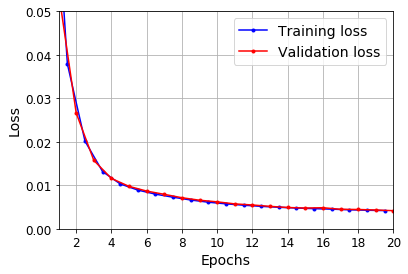

In [18]:
# Learning curve plot helper function
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label = "Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label = "Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer = True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize = 14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

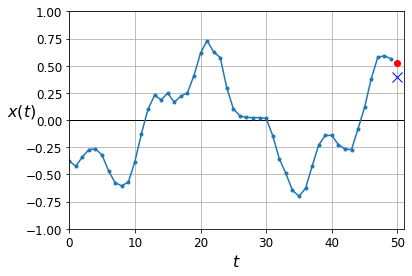

In [19]:
# Plot predictive performance
y_pred = model.predict(x_valid)
plot_series(x_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### 1.2 Simple RNN

Consider simplest RNN:
- Single layer with single neuron
- Recurrent neuron gets input and previous output

In [25]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape = [None, 1])
])

_Notes_ :
- First input dim = `None` : do not need to specify length due to RNN nature
- By default, `SimpleRNN` uses $\tanh$ activation
- Only returns the final output: if want intermediate outputs, need `return_sequences = True`

In [26]:
# Run the model
optimizer = keras.optimizers.Adam(lr = 0.005)
model.compile(loss = "mse", optimizer = optimizer)
history = model.fit(x_train, y_train, epochs = 20,
                   validation_data = (x_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0116 - val_loss: 0.0110

In [27]:
# Final valid score
model.evaluate(x_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0109


0.010881561785936356

Better than naive approach, but doesn't beat linear model

Difference in _number of parameters_ :
- Linear model: 50 inputs + bias (51)
- RNN: input, previous output, and bias (3)

__Key point__ : potentially helpful to remove trend & seasonality before RNN modeling! (though not always helpful...)

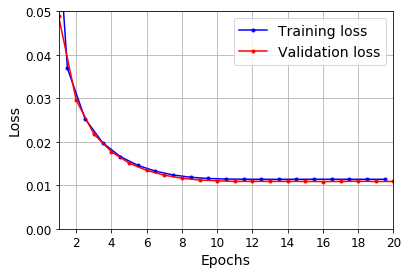

In [28]:
# Training plot
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

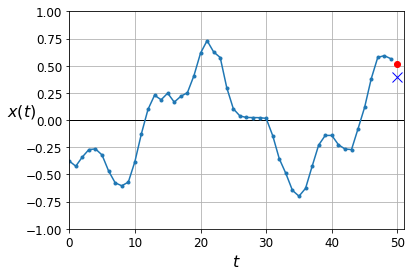

In [29]:
y_pred = model.predict(x_valid)
plot_series(x_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### 1.3 Deep RNNs

Stack multiple layers of cells for deep RNN; can implement in `tf.keras` with multiple `SimpleRNN` layers

#### 1.3.1 Version 1

In [30]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
    keras.layers.SimpleRNN(20, return_sequences = True),
    keras.layers.SimpleRNN(1)
])

_Note_ : we really only care about the final output (univariate time series); some redundancy using all of the outputs from the intermediate hidden layer

In [31]:
# Complile the model
model.compile(loss = "mse", optimizer = "adam")
history = model.fit(x_train, y_train, epochs = 20,
                   validation_data = (x_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0035 - val_lo

In [33]:
# Finally beat the linear model
model.evaluate(x_valid, y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0029


0.002910564187914133

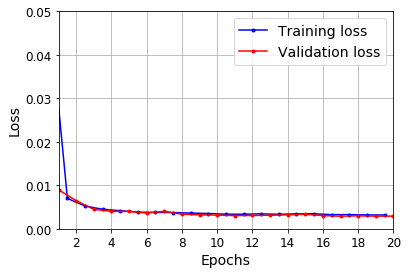

In [34]:
# Training
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

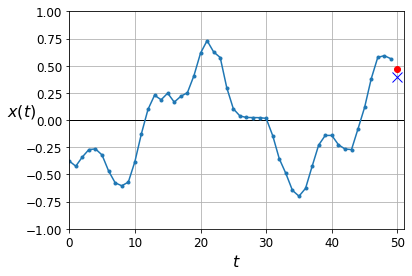

In [35]:
# Prediction
y_pred = model.predict(x_valid)
plot_series(x_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

#### 1.3.2 Version 2

_Better_ : make second `SimpleRNN` layer return only the last output
- Converges faster, and performs just as well
- Can also change the output activation if needed!

In [36]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss = "mse", optimizer = "adam")
history = model.fit(x_train, y_train, epochs = 20,
                   validation_data = (x_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0030 - val_los

In [37]:
model.evaluate(x_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0026


0.002623623702675104

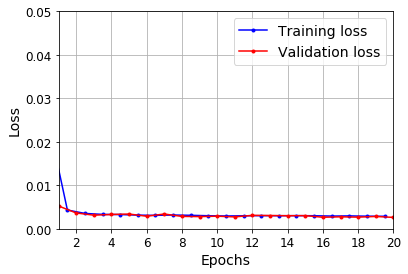

In [38]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

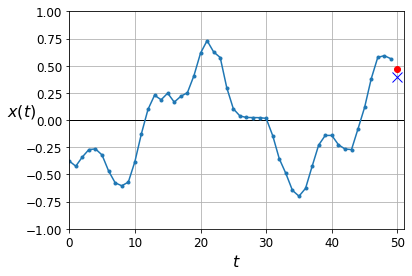

In [39]:
y_pred = model.predict(x_valid)
plot_series(x_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### 1.4 Forecasting several steps ahead